In [1]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
NUM_CLASSES = len(CLASS_LABELS)
label_dict = {i:CLASS_LABELS[i] for i in np.arange(NUM_CLASSES)}

In [3]:
df = pd.read_csv('fer2013.csv')

In [4]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


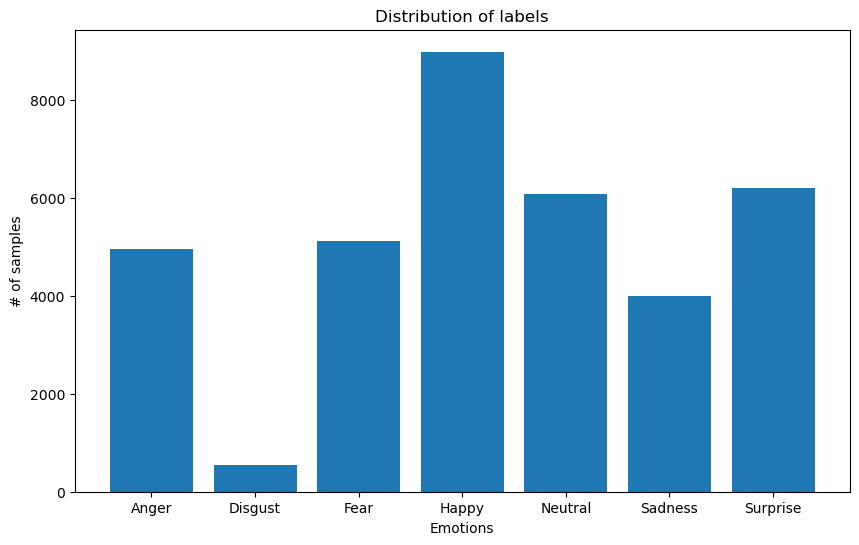

In [5]:
# Check distribution
plt.figure(figsize=(10,6))
plt.bar(CLASS_LABELS, [df['emotion'].tolist().count(i) for i in np.arange(NUM_CLASSES)])
plt.xlabel('Emotions')
plt.ylabel('# of samples')
plt.title('Distribution of labels')
plt.show()

In [6]:
# Transform df column with pixels into a pytorch tensor
pixels = df['pixels']
pixels = pixels.apply(lambda x: x.split(" ")).tolist()
pixels = np.uint8(pixels)
pixels = torch.Tensor(pixels)
pixels = torch.reshape(pixels, (pixels.shape[0], 1, 48, 48))

In [7]:
train_idx = df.index[df['Usage'] == 'Training'].tolist()
val_idx   = df.index[df['Usage'] == 'PublicTest'].tolist()
test_idx  = df.index[df['Usage'] == 'PrivateTest'].tolist()

X_train = pixels[train_idx]
y_train = torch.Tensor(df.iloc[train_idx]['emotion'].tolist())
X_val = pixels[val_idx]
y_val = torch.Tensor(df.iloc[val_idx]['emotion'].tolist())
X_test = pixels[test_idx]
y_test = torch.Tensor(df.iloc[test_idx]['emotion'].tolist())

In [8]:
print(f'Train set shape: {list(X_train.shape)}, labels shape: {list(y_train.shape)}')
print(f'Validation set shape: {list(X_val.shape)}, labels shape: {list(y_val.shape)}')
print(f'Test set shape: {list(X_test.shape)}, labels shape: {list(y_test.shape)}')

Train set shape: [28709, 1, 48, 48], labels shape: [28709]
Validation set shape: [3589, 1, 48, 48], labels shape: [3589]
Test set shape: [3589, 1, 48, 48], labels shape: [3589]


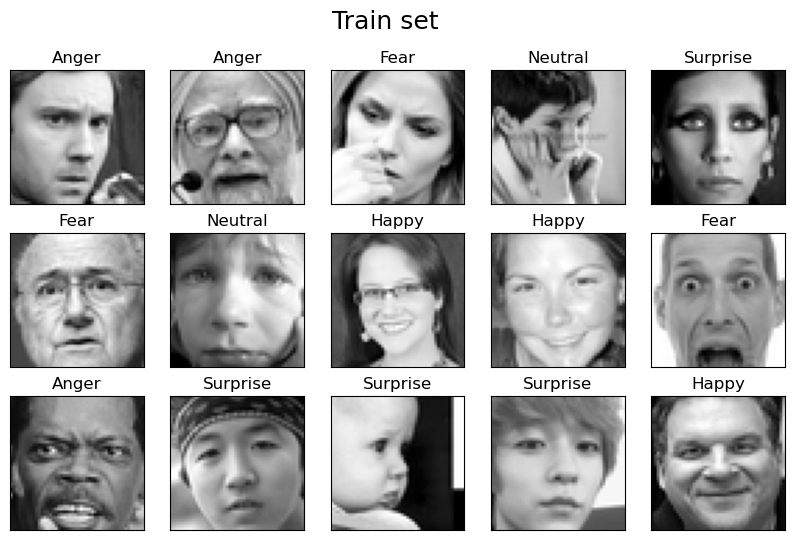

In [9]:
f, axarr = plt.subplots(3,5, figsize=(10,6))

for i in range(3):
    for j in range(5):
        axarr[i,j].imshow(X_train[5*i+j].squeeze(), cmap='gray')
        axarr[i,j].set_title(label_dict[int(y_train[5*i+j])])
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
plt.suptitle('Train set', fontsize=18)
plt.show()

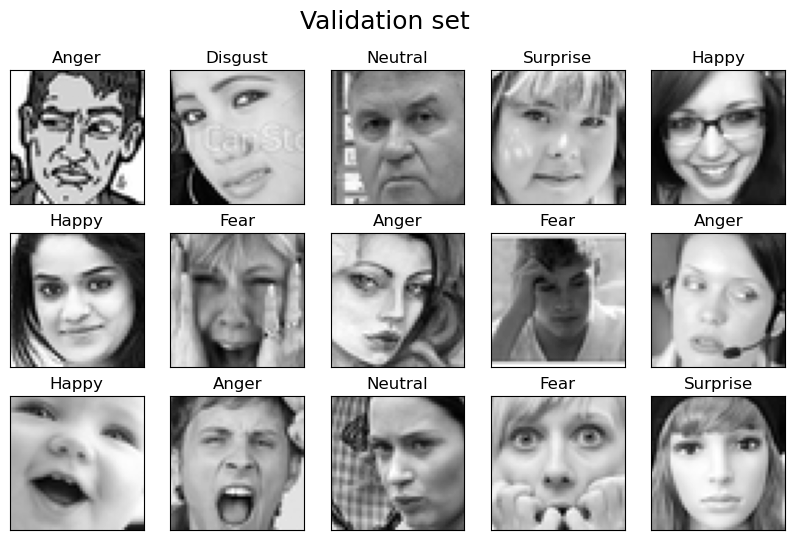

In [10]:
f, axarr = plt.subplots(3,5, figsize=(10,6))

for i in range(3):
    for j in range(5):
        axarr[i,j].imshow(X_val[5*i+j].squeeze(), cmap='gray')
        axarr[i,j].set_title(label_dict[int(y_val[5*i+j])])
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
plt.suptitle('Validation set', fontsize=18)
plt.show()

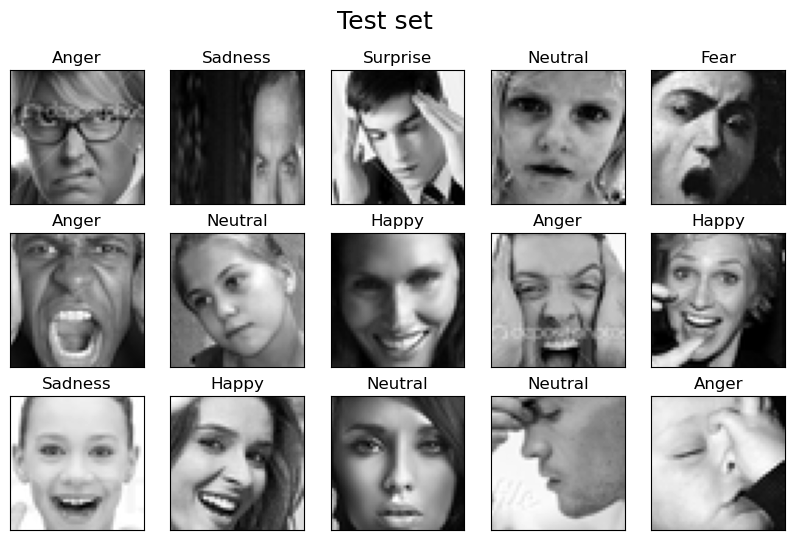

In [11]:
f, axarr = plt.subplots(3,5, figsize=(10,6))

for i in range(3):
    for j in range(5):
        axarr[i,j].imshow(X_test[5*i+j].squeeze(), cmap='gray')
        axarr[i,j].set_title(label_dict[int(y_test[5*i+j])])
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
plt.suptitle('Test set', fontsize=18)
plt.show()

In [12]:
class tensorDataset(Dataset):
    def __init__(self, images, labels, train:bool):
        self.images = images/255
        self.labels = labels
        self.train  = train
        

    def __getitem__(self, index):
        # Load the image (as tensor)
        img  = self.images[index]
        label = self.labels[index]
        
        # Apply transformations
        if self.train == True:
            img = self.transform(img)

        # Turn on gradient for image
        img = img.detach().clone().requires_grad_(True)
        
        return img, label

    
    def __len__(self):
        return len(self.images)
    
    
    def transform(self, img):
        # Horizontal flip
        if np.random.rand() < 0.3:
            t_horizonal_flip = T.RandomHorizontalFlip(p=1)
            img = t_horizonal_flip(img)

        # Add rotations
        if np.random.rand() < 0.3:
            t_rotation = T.RandomRotation(degrees=(-20, 20))
            img = t_rotation(img)

        return img

In [13]:
def create_dataloaders(batch_size, X_train, y_train, X_val, y_val, X_test=None, y_test=None):

    train_dataset = tensorDataset(X_train, y_train, train=True)
    val_dataset   = tensorDataset(X_val, y_val, train=False)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader   = DataLoader(val_dataset  , batch_size=BATCH_SIZE, shuffle=False)

    if X_test is not None:
        test_dataset  = tensorDataset(X_test, y_test, train=False)
        test_dataloader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False)
        return train_dataloader, val_dataloader, test_dataloader
    
    return train_dataloader, val_dataloader

In [14]:
class ED_model(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        super(ED_model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(p=0.3)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(p=0.3)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 48x48 -> 24x24
        self.dropout3 = nn.Dropout(p=0.3)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(p=0.3)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn5 = nn.BatchNorm2d(128)
        self.dropout5 = nn.Dropout(p=0.3)

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn6 = nn.BatchNorm2d(128)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 24x24 -> 12x12
        self.dropout6 = nn.Dropout(p=0.3)

        self.conv7 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn7 = nn.BatchNorm2d(64)
        self.dropout7 = nn.Dropout(p=0.3)

        self.conv8 = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding='same', bias=False)
        self.bn8 = nn.BatchNorm2d(16)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 12x12 -> 6x6
        self.dropout8 = nn.Dropout(p=0.3)

        self.fc1 = nn.Linear(in_features=6*6*16, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=32)
        self.fc3 = nn.Linear(32, out_channels)


    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x) # <- block 1
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x) # <- block 2
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.dropout3(x) # <- block 3
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout4(x) # <- block 4
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.dropout5(x) # <- block 5
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = self.dropout6(x) # <- block 6

        x = self.conv7(x)
        x = self.bn7(x)
        x = F.relu(x)
        x = self.dropout7(x) # <- block 7
        x = self.conv8(x)
        x = self.bn8(x)
        x = F.relu(x)
        x = self.max_pool3(x)
        x = self.dropout8(x) # <- block 8

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)

        return x

In [15]:
!pip install torchinfo
from torchinfo import summary

In [16]:
model = ED_model(in_channels=1, out_channels=NUM_CLASSES)
summary(model, input_size=(99, 1, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
ED_model                                 [99, 7]                   --
├─Conv2d: 1-1                            [99, 16, 48, 48]          144
├─BatchNorm2d: 1-2                       [99, 16, 48, 48]          32
├─Dropout: 1-3                           [99, 16, 48, 48]          --
├─Conv2d: 1-4                            [99, 64, 48, 48]          9,216
├─BatchNorm2d: 1-5                       [99, 64, 48, 48]          128
├─Dropout: 1-6                           [99, 64, 48, 48]          --
├─Conv2d: 1-7                            [99, 128, 48, 48]         73,728
├─BatchNorm2d: 1-8                       [99, 128, 48, 48]         256
├─MaxPool2d: 1-9                         [99, 128, 24, 24]         --
├─Dropout: 1-10                          [99, 128, 24, 24]         --
├─Conv2d: 1-11                           [99, 128, 24, 24]         147,456
├─BatchNorm2d: 1-12                      [99, 128, 24, 24]         256

In [17]:
def train():

    for epoch in range(1, EPOCHS+1):
        # Train model
        model.train()
        train_losses   = []
        train_accuracy = []
        train_f1       = []

        for i, batch in enumerate(train_dataloader):
            #Extract data, labels
            img_batch, label_batch = batch   #img [B,3,H,W], label[B,N_CLASSES]
            img_batch = img_batch.to(DEVICE)
            label_batch = label_batch.type(torch.LongTensor).to(DEVICE)

            #Train model
            optimizer.zero_grad()
            output = model(img_batch) # output: [B, 7, H, W]
            loss   = criterion(output, label_batch)
            loss.backward()
            optimizer.step()

            #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
            preds = torch.argmax(output, dim=1)
            f1 = f1_score(preds.cpu(), label_batch.cpu(), average='macro')
            acc = torch.sum(preds == label_batch) / len(preds)
            train_losses.append(loss.item())
            train_accuracy.append(acc.cpu())
            train_f1.append(f1)
            # print(f'Train Epoch: {epoch}, batch: {i} | Batch metrics | loss: {loss.item():.4f}, f1: {f1:.3f}, accuracy: {acc:.3f}')

        # Update global metrics
        print(f'TRAIN       Epoch: {epoch} | Epoch metrics | loss: {np.mean(train_losses):.4f}, f1: {np.mean(train_f1):.3f}, accuracy: {np.mean(train_accuracy):.3f}, learning rate: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')        
        total_train_losses.append(np.mean(train_losses))
        total_train_accuracy.append(np.mean(train_accuracy))
        total_train_f1.append(np.mean(train_f1))

        #Update learning rate
        learning_rate_tracker.append(optimizer.state_dict()['param_groups'][0]['lr'])
        scheduler.step()

        # Validate model
        model.eval()
        val_losses   = []
        val_accuracy = []
        val_f1       = []

        for i, batch in enumerate(val_dataloader):
            #Extract data, labels
            img_batch, label_batch = batch
            img_batch = img_batch.to(DEVICE)
            label_batch = label_batch.type(torch.LongTensor).to(DEVICE)

            #Validate model
            with torch.cuda.amp.autocast():
                output = model(img_batch)
                loss   = criterion(output, label_batch)

            #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
            preds = torch.argmax(output, dim=1)
            f1 = f1_score(preds.cpu(), label_batch.cpu(), average='macro')
            acc = torch.sum(preds == label_batch) / len(preds)
            val_losses.append(loss.item())
            val_accuracy.append(acc.cpu())
            val_f1.append(f1)
            # print(f'Val Epoch: {epoch}, batch: {i} | Batch metrics | loss: {loss.item():.4f}, f1: {f1:.3f}, accuracy: {acc:.3f}')

        # Update global metrics
        print(f'VALIDATION  Epoch: {epoch} | Epoch metrics | loss: {np.mean(val_losses):.4f}, f1: {np.mean(val_f1):.3f}, accuracy: {np.mean(val_accuracy):.3f}')
        print('-'*106)
        total_val_losses.append(np.mean(val_losses))
        total_val_accuracy.append(np.mean(val_accuracy))
        total_val_f1.append(np.mean(val_f1))


        # Save the results so far
        temp_df = pd.DataFrame(list(zip(total_train_losses, total_val_losses, total_train_f1, total_val_f1,
                                    total_train_accuracy, total_val_accuracy)),
                            columns = ['train_loss', 'val_loss', 'train_f1', 'test_f1', 'train_accuracy',
                                      'test_accuracy'])
        temp_df.to_csv('train_val_measures')

In [18]:
# HYPERPARAMETERS for training run
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 60
LR = 0.01
BATCH_SIZE = 64
max_split_size_mb = 200
torch.backends.cuda.split_kernel_size = max_split_size_mb * 1024 * 1024

model = ED_model(in_channels=1, out_channels=NUM_CLASSES).to(DEVICE)
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE, X_train, y_train, X_val, y_val, X_test, y_test)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1) # Use dynamic learning rate
criterion = nn.CrossEntropyLoss().to(DEVICE)

total_train_losses    = []
total_val_losses      = []
total_train_accuracy  = []
total_val_accuracy    = []
total_train_f1        = []
total_val_f1          = []
learning_rate_tracker = []

In [19]:
import time

In [20]:
startTime = time.time()
train()

TRAIN       Epoch: 1 | Epoch metrics | loss: 1.8862, f1: 0.091, accuracy: 0.253, learning rate: 0.010000
VALIDATION  Epoch: 1 | Epoch metrics | loss: 1.8634, f1: 0.119, accuracy: 0.280
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 2 | Epoch metrics | loss: 1.8479, f1: 0.163, accuracy: 0.293, learning rate: 0.010000
VALIDATION  Epoch: 2 | Epoch metrics | loss: 1.8231, f1: 0.188, accuracy: 0.338
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 3 | Epoch metrics | loss: 1.8208, f1: 0.201, accuracy: 0.322, learning rate: 0.010000
VALIDATION  Epoch: 3 | Epoch metrics | loss: 1.8401, f1: 0.205, accuracy: 0.305
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 4 | Epoch metrics | loss: 1.8027, f1: 0.224, accuracy: 0.342, learning rate: 0.010000
VALIDATION  Epoch: 

TRAIN       Epoch: 29 | Epoch metrics | loss: 1.7546, f1: 0.264, accuracy: 0.395, learning rate: 0.001000
VALIDATION  Epoch: 29 | Epoch metrics | loss: 1.7389, f1: 0.266, accuracy: 0.406
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 30 | Epoch metrics | loss: 1.7572, f1: 0.258, accuracy: 0.393, learning rate: 0.001000
VALIDATION  Epoch: 30 | Epoch metrics | loss: 1.7314, f1: 0.278, accuracy: 0.416
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 31 | Epoch metrics | loss: 1.7532, f1: 0.268, accuracy: 0.399, learning rate: 0.001000
VALIDATION  Epoch: 31 | Epoch metrics | loss: 1.7248, f1: 0.289, accuracy: 0.422
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 32 | Epoch metrics | loss: 1.7503, f1: 0.274, accuracy: 0.401, learning rate: 0.001000
VALIDATION  

TRAIN       Epoch: 57 | Epoch metrics | loss: 1.7428, f1: 0.282, accuracy: 0.407, learning rate: 0.000100
VALIDATION  Epoch: 57 | Epoch metrics | loss: 1.7232, f1: 0.305, accuracy: 0.438
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 58 | Epoch metrics | loss: 1.7437, f1: 0.281, accuracy: 0.406, learning rate: 0.000100
VALIDATION  Epoch: 58 | Epoch metrics | loss: 1.7225, f1: 0.307, accuracy: 0.440
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 59 | Epoch metrics | loss: 1.7414, f1: 0.283, accuracy: 0.409, learning rate: 0.000100
VALIDATION  Epoch: 59 | Epoch metrics | loss: 1.7228, f1: 0.307, accuracy: 0.439
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 60 | Epoch metrics | loss: 1.7440, f1: 0.279, accuracy: 0.406, learning rate: 0.000100
VALIDATION  

In [21]:
print("time for training the model is : ", round((time.time()-startTime)/60, 2), "minutes")

time for training the model is :  83.55 minutes


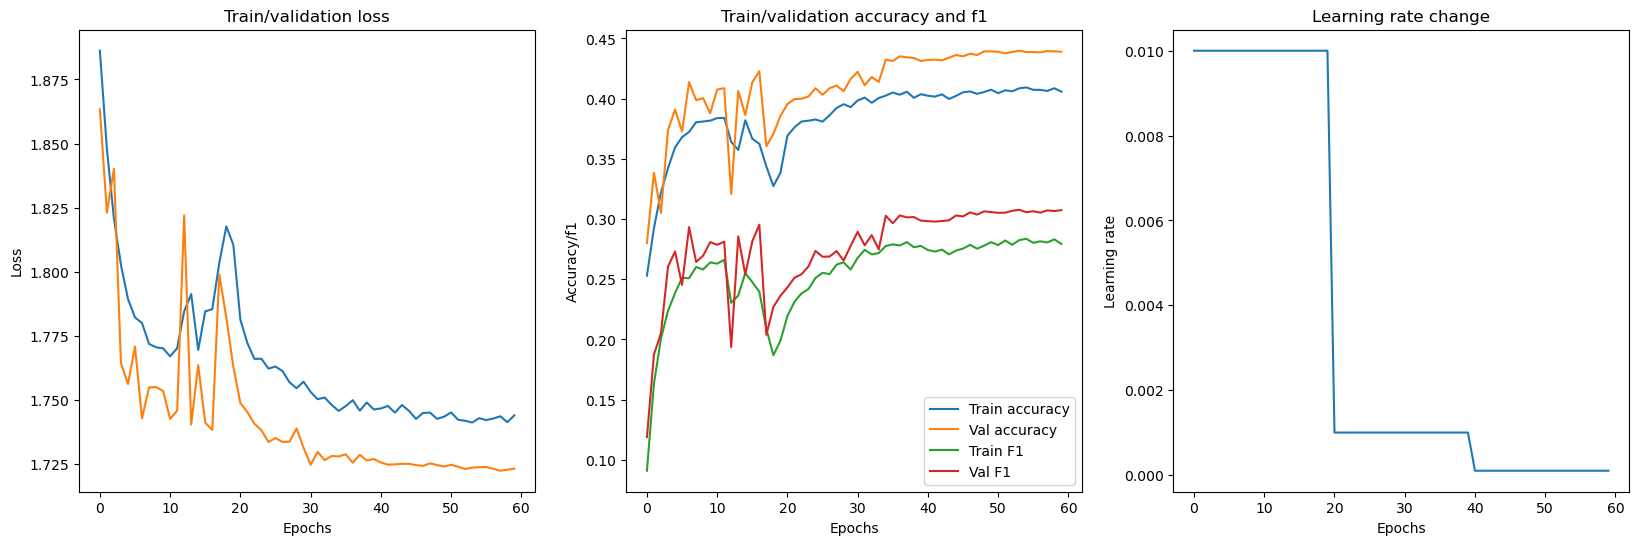

In [22]:
f, axarr = plt.subplots(1,3, figsize = (20,6))
axarr[0].plot(list(range(len(total_train_losses))), total_train_losses)
axarr[0].plot(list(range(len(total_train_losses))), total_val_losses)
axarr[0].set_title('Train/validation loss')
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

axarr[1].plot(list(range(len(total_train_accuracy))), total_train_accuracy, label='Train accuracy')
axarr[1].plot(list(range(len(total_train_accuracy))), total_val_accuracy, label='Val accuracy')
axarr[1].plot(list(range(len(total_train_accuracy))), total_train_f1, label='Train F1')
axarr[1].plot(list(range(len(total_train_accuracy))), total_val_f1, label='Val F1')
axarr[1].set_title('Train/validation accuracy and f1')
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Accuracy/f1')
axarr[1].legend()

axarr[2].plot(np.arange(len(learning_rate_tracker)), learning_rate_tracker)
axarr[2].set_title('Learning rate change')
axarr[2].set_xlabel('Epochs')
axarr[2].set_ylabel('Learning rate')
plt.show()

In [23]:
preds = []
labels = []

for img_batch, label_batch in val_dataloader:
    img_batch = img_batch.to(DEVICE)
    output = model(img_batch)

    labels.extend(label_batch.type(torch.uint8).tolist())
    preds.extend(torch.argmax(output, dim=1).tolist())

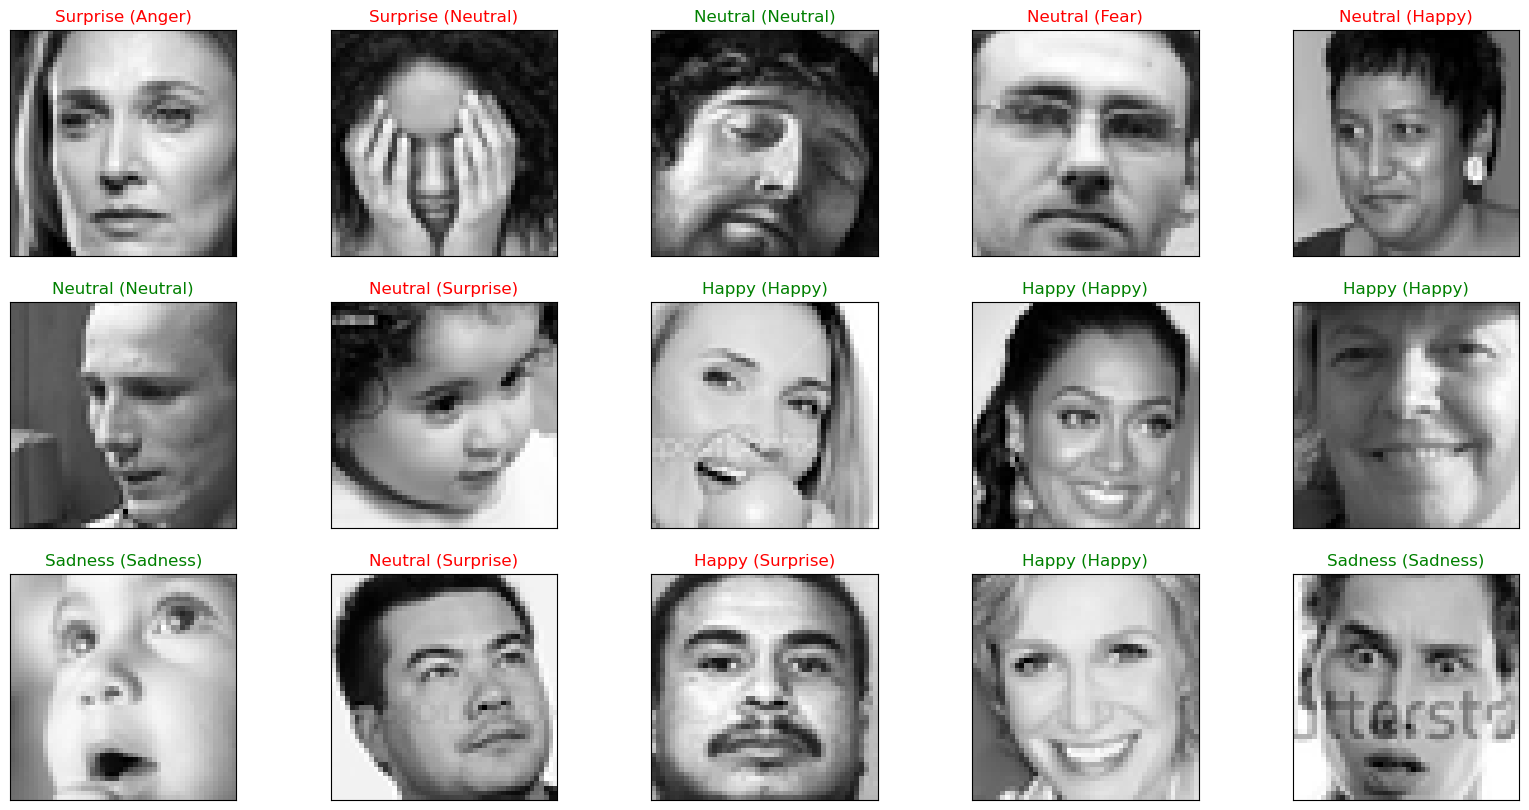

In [24]:
f, axarr = plt.subplots(3,5, figsize=(20,10))

for i in range(3):
    for j in range(5):
        const = np.random.randint(0, len(labels)-15)
        idx = const + i*5+j
        axarr[i,j].imshow(X_val[idx].squeeze(), cmap='gray')
        axarr[i,j].set_title(f'{label_dict[preds[idx]]} ({label_dict[labels[idx]]})', color=('green' if preds[idx]==labels[idx] else 'red'))
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])

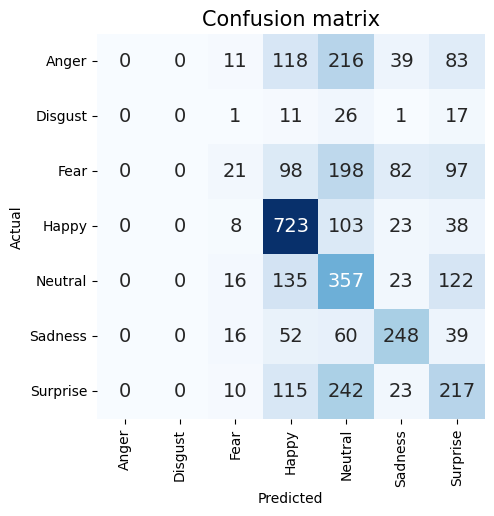

In [26]:
import seaborn as sns
cm_data = confusion_matrix(labels, preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

plt.figure(figsize=(5,5))
plt.title('Confusion matrix', fontsize=15)
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, annot_kws={'size':14}, fmt='g')
plt.show()

In [27]:
from sklearn.metrics import classification_report
print(classification_report(labels, preds, digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       467
           1      0.000     0.000     0.000        56
           2      0.253     0.042     0.073       496
           3      0.577     0.808     0.673       895
           4      0.297     0.547     0.385       653
           5      0.565     0.598     0.581       415
           6      0.354     0.357     0.356       607

    accuracy                          0.436      3589
   macro avg      0.292     0.336     0.295      3589
weighted avg      0.358     0.436     0.375      3589



In [28]:
import matplotlib.image as mpimg

In [30]:
img = mpimg.imread('Riya_pic.jpg')
img = torch.from_numpy(img.copy())

transforms = torch.nn.Sequential(
    T.Resize((48,48)),
    T.Grayscale(num_output_channels=1)
)

img = transforms(img.permute(2,0,1)) / 255

In [31]:
output = model(img.type(torch.FloatTensor).unsqueeze(dim=0).to(DEVICE))
label = int(torch.argmax(output))

Neutral


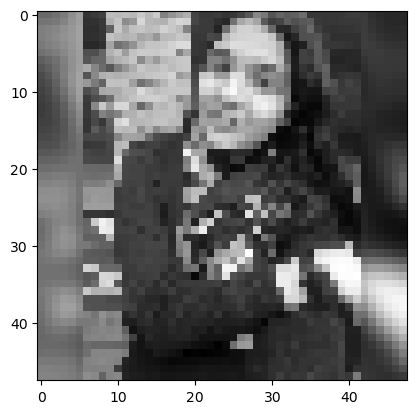

In [33]:
print(label_dict[label])
plt.imshow(img.squeeze(), cmap='gray')
# plt.
plt.show()